In [5]:
import torch
import torch.nn as nn
import torch.optim as optim
from torchvision import datasets, transforms
from torch.utils.data import DataLoader
import os
import numpy as np


BATCH_SIZE = 32
NUM_FILTERS = 256
STEP_SIZE = 20
DROPOUT = 0.2
LEARNING_RATE = 0.0002
USE_BATCH_NORM = True


base_path = 'D:/CNN_L/dataset'
train_path = os.path.join(base_path, 'train')  
test_path = os.path.join(base_path, 'test')   


train_transform = transforms.Compose([
    transforms.Resize((256, 256)),  
    transforms.RandomResizedCrop(224, scale=(0.8, 1.0)), 
    transforms.RandomHorizontalFlip(p=0.5), 
    transforms.RandomVerticalFlip(p=0.1),  
    transforms.RandomRotation(15), 
    transforms.RandomAffine(degrees=0, translate=(0.1, 0.1)), 
    transforms.ColorJitter(brightness=0.2, contrast=0.2, saturation=0.2, hue=0.1), 
    transforms.RandomPerspective(distortion_scale=0.2, p=0.1), 
    transforms.GaussianBlur(kernel_size=3, sigma=(0.1, 0.5)), 
    transforms.ToTensor(),
    transforms.Normalize(mean=[0.485, 0.456, 0.406], std=[0.229, 0.224, 0.225])
])



test_transform = transforms.Compose([
    transforms.Resize((224, 224)),
    transforms.ToTensor(),
    transforms.Normalize(mean=[0.485, 0.456, 0.406], std=[0.229, 0.224, 0.225])
])


train_dataset = datasets.ImageFolder(root=train_path, transform=train_transform)
test_dataset = datasets.ImageFolder(root=test_path, transform=test_transform)


print("اطلاعات دیتاست آموزشی:")
print(f"تعداد کل نمونه‌ها: {len(train_dataset)}")
print(f"تعداد کلاس‌ها: {len(train_dataset.classes)}")
print(f"نام کلاس‌ها: {train_dataset.classes}")
print(f"تعداد نمونه‌های هر کلاس: {np.bincount(train_dataset.targets)}")

print("\nاطلاعات دیتاست تست:")
print(f"تعداد کل نمونه‌ها: {len(test_dataset)}")
print(f"تعداد کلاس‌ها: {len(test_dataset.classes)}")
print(f"نام کلاس‌ها: {test_dataset.classes}")
print(f"تعداد نمونه‌های هر کلاس: {np.bincount(test_dataset.targets)}")


train_loader = DataLoader(train_dataset, batch_size=BATCH_SIZE, shuffle=True, num_workers=4)
test_loader = DataLoader(test_dataset, batch_size=BATCH_SIZE, shuffle=False, num_workers=4)


class CNNModel(nn.Module):
    def __init__(self, num_classes=2):
        super(CNNModel, self).__init__()
        
      
        self.features = nn.Sequential(
            nn.Conv2d(3, NUM_FILTERS//4, kernel_size=3, padding=1),
            nn.BatchNorm2d(NUM_FILTERS//4) if USE_BATCH_NORM else nn.Identity(),
            nn.ReLU(inplace=True),
            nn.MaxPool2d(2),
            
            nn.Conv2d(NUM_FILTERS//4, NUM_FILTERS//2, kernel_size=3, padding=1),
            nn.BatchNorm2d(NUM_FILTERS//2) if USE_BATCH_NORM else nn.Identity(),
            nn.ReLU(inplace=True),
            nn.MaxPool2d(2),
            
            nn.Conv2d(NUM_FILTERS//2, NUM_FILTERS, kernel_size=3, padding=1),
            nn.BatchNorm2d(NUM_FILTERS) if USE_BATCH_NORM else nn.Identity(),
            nn.ReLU(inplace=True),
            nn.AdaptiveAvgPool2d((1, 1))
        )   
    
        self.classifier = nn.Sequential(
            nn.Dropout(DROPOUT),
            nn.Linear(NUM_FILTERS, num_classes)
        )
    
    def forward(self, x):
        x = self.features(x)
        x = torch.flatten(x, 1)
        x = self.classifier(x)
        return x


device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
print(f"\nUsing device: {device}")


model = CNNModel().to(device)
criterion = nn.CrossEntropyLoss()
optimizer = optim.Adam(model.parameters(), lr=LEARNING_RATE)
scheduler = optim.lr_scheduler.StepLR(optimizer, step_size=STEP_SIZE, gamma=0.1)


class EarlyStopping:
    def __init__(self, patience=10, verbose=False):
        self.patience = patience
        self.counter = 0
        self.best_loss = None
        self.early_stop = False
        self.verbose = verbose

    def __call__(self, val_loss, model):
        if self.best_loss is None or val_loss < self.best_loss:
            self.best_loss = val_loss
            self.counter = 0
            if self.verbose:
                print(f"Validation loss decreased to {val_loss:.4f}. Saving model...")
            torch.save(model.state_dict(), 'best_model.pth')
        else:
            self.counter += 1
            if self.counter >= self.patience:
                self.early_stop = True
                if self.verbose:
                    print("Early stopping activated.")

early_stopping = EarlyStopping(patience=10, verbose=True)


num_epochs = 10
best_accuracy = 0.0

print("\nشروع آموزش مدل با پارامترهای زیر:")
print(f"Batch size: {BATCH_SIZE}")
print(f"Number of filters: {NUM_FILTERS}")
print(f"Step size for LR scheduler: {STEP_SIZE}")
print(f"Dropout rate: {DROPOUT}")
print(f"Learning rate: {LEARNING_RATE}")
print(f"Batch normalization: {'Enabled' if USE_BATCH_NORM else 'Disabled'}")
print(f"Early stopping: Enabled (patience=10)")

for epoch in range(num_epochs):
    model.train()
    train_loss = 0.0
    train_correct = 0
    train_total = 0
    
 
    for images, labels in train_loader:
        images, labels = images.to(device), labels.to(device)
        
        optimizer.zero_grad()
        outputs = model(images)
        loss = criterion(outputs, labels)
        loss.backward()
        optimizer.step()
        
        train_loss += loss.item() * images.size(0)
        _, predicted = torch.max(outputs.data, 1)
        train_total += labels.size(0)
        train_correct += (predicted == labels).sum().item()
    

    train_loss = train_loss / len(train_loader.dataset)
    train_accuracy = 100 * train_correct / train_total
    
 
    model.eval()
    val_loss = 0.0
    val_correct = 0
    val_total = 0
    
    with torch.no_grad():
        for images, labels in test_loader:
            images, labels = images.to(device), labels.to(device)
            outputs = model(images)
            loss = criterion(outputs, labels)
            
            val_loss += loss.item() * images.size(0)
            _, predicted = torch.max(outputs.data, 1)
            val_total += labels.size(0)
            val_correct += (predicted == labels).sum().item()
    

    val_loss = val_loss / len(test_loader.dataset)
    val_accuracy = 100 * val_correct / val_total
    
 
    scheduler.step()
    
  
    print(f"\nEpoch {epoch+1}/{num_epochs}:")
    print(f"Train Loss: {train_loss:.4f} | Train Acc: {train_accuracy:.2f}%")
    print(f"Val Loss: {val_loss:.4f} | Val Acc: {val_accuracy:.2f}%")
    print(f"Current LR: {scheduler.get_last_lr()[0]:.6f}")
    

    if val_accuracy > best_accuracy:
        best_accuracy = val_accuracy
        torch.save(model.state_dict(), 'best_model.pth')
        print(f"New best model saved with accuracy {best_accuracy:.2f}%")
    
 
    early_stopping(val_loss, model)
    if early_stopping.early_stop:
        print("\nEarly stopping triggered.")
        break


model.load_state_dict(torch.load('best_model.pth'))
model.eval()


test_correct = 0
test_total = 0

with torch.no_grad():
    for images, labels in test_loader:
        images, labels = images.to(device), labels.to(device)
        outputs = model(images)
        _, predicted = torch.max(outputs.data, 1)
        test_total += labels.size(0)
        test_correct += (predicted == labels).sum().item()

print(f'\nدقت نهایی مدل روی مجموعه تست: {100 * test_correct / test_total:.2f}%')
print(f'بهترین دقت ارزیابی: {best_accuracy:.2f}%')

اطلاعات دیتاست آموزشی:
تعداد کل نمونه‌ها: 592
تعداد کلاس‌ها: 2
نام کلاس‌ها: ['abnormal', 'normal']
تعداد نمونه‌های هر کلاس: [441 151]

اطلاعات دیتاست تست:
تعداد کل نمونه‌ها: 278
تعداد کلاس‌ها: 2
نام کلاس‌ها: ['abnormal', 'normal']
تعداد نمونه‌های هر کلاس: [224  54]

Using device: cpu

شروع آموزش مدل با پارامترهای زیر:
Batch size: 32
Number of filters: 256
Step size for LR scheduler: 20
Dropout rate: 0.2
Learning rate: 0.0002
Batch normalization: Enabled
Early stopping: Enabled (patience=10)

Epoch 1/10:
Train Loss: 0.3822 | Train Acc: 84.63%
Val Loss: 0.2291 | Val Acc: 90.29%
Current LR: 0.000200
New best model saved with accuracy 90.29%
Validation loss decreased to 0.2291. Saving model...

Epoch 2/10:
Train Loss: 0.2733 | Train Acc: 89.86%
Val Loss: 0.2078 | Val Acc: 95.32%
Current LR: 0.000200
New best model saved with accuracy 95.32%
Validation loss decreased to 0.2078. Saving model...

Epoch 3/10:
Train Loss: 0.2419 | Train Acc: 91.05%
Val Loss: 0.1179 | Val Acc: 100.00%
Current LR

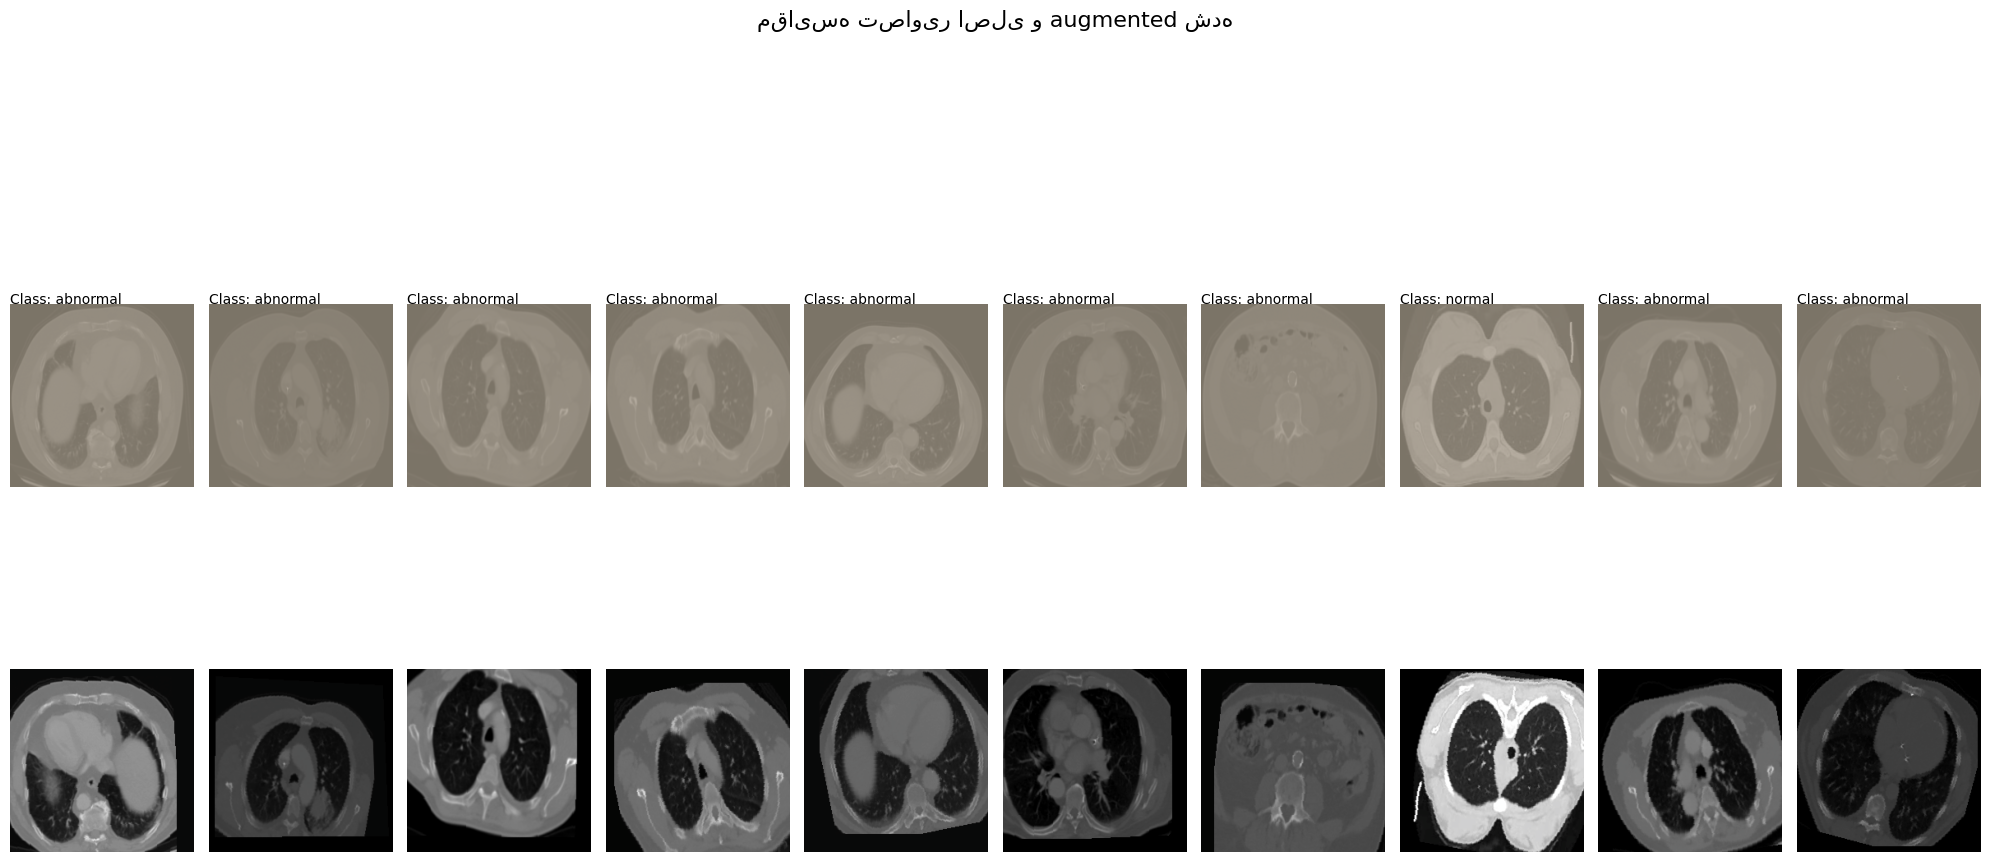

In [11]:
import matplotlib.pyplot as plt
import numpy as np
from torchvision.datasets.folder import default_loader

def imshow(img, title=None):

    img = img.numpy().transpose((1, 2, 0))  
    mean = np.array([0.485, 0.456, 0.406])
    std = np.array([0.229, 0.224, 0.225])
    img = std * img + mean  
    img = np.clip(img, 0, 1)  
    plt.imshow(img)
    if title is not None:
        plt.title(title)
    plt.axis('off')


original_transform = transforms.Compose([
    transforms.Resize((224, 224)),
    transforms.ToTensor(),
])


num_samples = 10
indices = np.random.choice(len(train_dataset), num_samples, replace=False)


plt.figure(figsize=(20, 10))

for i, idx in enumerate(indices):
 
    img_path, label = train_dataset.samples[idx]
    
 
    original_img = default_loader(img_path)
    
   
    img_original_transformed = original_transform(original_img)
    
  
    img_augmented = train_transform(original_img)
    
 
    plt.subplot(2, num_samples, i+1)
    imshow(img_original_transformed)
    plt.text(0, -15, f"Class: {train_dataset.classes[label]}", ha='left', va='top', fontsize=10)
    
   
    plt.subplot(2, num_samples, num_samples + i + 1)
    imshow(img_augmented)

plt.suptitle('مقایسه تصاویر اصلی و augmented شده', fontsize=16, y=1.05)
plt.tight_layout()
plt.show()

In [12]:
from PIL import Image
import torch.nn.functional as F

def predict_image(image_path, model, transform, device, class_names):
   
   
    image = Image.open(image_path).convert('RGB') 
    

    image = transform(image).unsqueeze(0).to(device) 
    
    model.eval()
    with torch.no_grad():
        output = model(image)
        probabilities = F.softmax(output, dim=1)
        confidence, predicted_idx = torch.max(probabilities, 1)
        confidence = confidence.item()
        predicted_idx = predicted_idx.item()
    
   
    predicted_class = class_names[predicted_idx]
    
    return predicted_class, confidence

In [13]:

model.load_state_dict(torch.load('best_model.pth'))
model.to(device)


class_names = train_dataset.classes 


new_image_path = 'D:/pictu.png'


predicted_class, confidence = predict_image(
    image_path=new_image_path,
    model=model,
    transform=test_transform, 
    device=device,
    class_names=class_names
)

print(f"\nتصویر: {new_image_path}")
print(f"کلاس پیش‌بینی شده: {predicted_class}")
print(f"میزان اطمینان: {confidence*100:.2f}%")


تصویر: D:/pictu.png
کلاس پیش‌بینی شده: abnormal
میزان اطمینان: 99.35%


In [14]:

from PIL import Image
Image.open('D:/pictu.png').show()